# Load model performance summary object


In [1]:
# Get directory path
import os
directory = os.getcwd()

# Specify filename
filename = "GBR_performance_summary"

# Show full filepath
full_file_path_GBR = directory + r"\\" + filename
print("Full path to file:", full_file_path_GBR)


def load_performance_summary(full_file_path):
    import pickle
    performance_df = pickle.load(open(full_file_path, "rb"))
    return performance_df

# Get performance summary object
perf_summary = load_performance_summary(full_file_path_GBR)
# perf_summary # show imported dataframe


Full path to file: C:\Users\2270577A\PycharmProjects\PhD_LCA_TEA\analysis\preliminary\ML_models_prediction_boundaries_and_errors\\GBR_performance_summary


In [2]:
# Get general variables
column_labels = perf_summary.columns


from config import settings
output_units = settings.labels.output_units
output_units = ["[vol.% db]", '[vol.% db]', '[vol.% db]', '[vol.% db]', '[vol.% db]', '[vol.% db]', '[MJ/N$m^{3}$]',
                '[g/N$m^{3}$]', '[N$m^{3}$/kg wb]', '[g/kg wb]']  # update output units for plotting with Latex
print("Column labels:", column_labels)
print("Output units:", output_units)


Column labels: Index(['N2 [vol.% db]', 'H2 [vol.% db]', 'CO [vol.% db]', 'CO2 [vol.% db]',
       'CH4 [vol.% db]', 'C2Hn [vol.% db]', 'LHV [MJ/Nm3]', 'Tar [g/Nm3]',
       'Gas yield [Nm3/kg wb]', 'Char yield [g/kg wb]'],
      dtype='object')
Output units: ['[vol.% db]', '[vol.% db]', '[vol.% db]', '[vol.% db]', '[vol.% db]', '[vol.% db]', '[MJ/N$m^{3}$]', '[g/N$m^{3}$]', '[N$m^{3}$/kg wb]', '[g/kg wb]']


# Define general functions required

In [3]:
# Define function to get cross validated predictions for model output
def get_CV_predictions_df(column_label):
    # Load model itself
    import pickle
    model = pickle.loads(perf_summary[column_label]['model'])

    # Calculate CV score again
    import pandas as pd
    import numpy as np

    # Combine datasets again before calculating cross validation scores
    x_complete = np.array(pd.concat([perf_summary[column_label]['x_train'],
                                     perf_summary[column_label]['x_test']]))
    y_complete = np.array(pd.concat([perf_summary[column_label]['y_train'],
                                     perf_summary[column_label]['y_test']]))

    from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
    
    # Calculate and print cross validated R2 scores
    from math import sqrt
    CV_R2_scores = cross_val_score(model, x_complete, y_complete, cv=5, scoring='r2')
    CV_MSE_scores= cross_val_score(model, x_complete, y_complete, cv=5, scoring='neg_mean_squared_error')

    # print("CV R2 scores: ", CV_R2_scores)
    print("Averaged CV R2 score: ", np.mean(CV_R2_scores))
    print("Averaged CV RMSE score: ", sqrt(-np.mean(CV_MSE_scores)))

    # # Get individual cross_validated models
    # Cross_val_test = cross_validate(model, x_complete, y_complete, return_estimator=True)
    # print("CV R2 score: ", Cross_val_test) 
    
    # Get cross validated predictions
    cv_predictions = cross_val_predict(model, x_complete, y_complete)

    # Create Dataframe to store targets and predictions
    import pandas as pd
    summary_df = pd.DataFrame([y_complete, cv_predictions]).transpose()
    summary_df.columns = ["targets", "predictions"]

    import matplotlib.pyplot as plt
    plt.scatter(cv_predictions, y_complete)
    # Note: Targets and predictors swapped here in this graph - this way would split along x-axis (i.e. vertical lines)
    plt.xlabel("Predictions")
    plt.ylabel("Targets")
    plt.show()
    
    return summary_df


In [4]:
# Kernel density estimation calculation and plots for tuning
def Kernel_Density_Tuning(summary_df, output_label_no, bandwidth):
    import numpy as np
    import pandas as pd
    from sklearn.neighbors import KernelDensity
    from scipy.signal import argrelextrema
    import matplotlib.pyplot as plt
    updated_summary_df = summary_df.copy()
    
    # Fit Kernel density model 
    pred = np.array(summary_df['predictions']).reshape(-1, 1) # get prediction in right formation for training
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pred) # fit kernel density estimation model
    scaling_var = (max(summary_df['predictions'])- min(summary_df['predictions']))*0.10 # get scaling variable for plotting
    x_axis = np.linspace(min(summary_df['predictions']) - scaling_var, max(summary_df['predictions']) + scaling_var) # create x-axis for plotting
    y = kde.score_samples(x_axis.reshape(-1,1)) # create curve
    
    kde_min_idx, kde_max_idx = argrelextrema(y, np.less)[0], argrelextrema(y, np.greater)[0] # get indices of minima and maxima of curve 
    minimas = x_axis[kde_min_idx] # extract minimas
    maximas = x_axis[kde_max_idx] # extract maximas
    print("Minimas:", minimas)
    print("Maximas:", maximas)
    
    # Create array with bin limits
    bin_limits = list(minimas.copy()) # get cut-offs
    bin_limits.append(max(summary_df['predictions']))  # add max value of all predictions
    bin_limits.insert(0, min(summary_df['predictions'])) # add min value of all predictions
    print("Bin Limits:", bin_limits)
    
    # add bin label column to dataframe
    bins = ["bin_1"] # initialise bins list
    for count, items in enumerate(minimas): # extract number of bins required
        bins.append("bin_" + str(count+2))
    updated_summary_df['bins'] = pd.cut(updated_summary_df['predictions'],
                                       bins=bin_limits,
                                       labels=bins,
                                       include_lowest=True)
    
    # Show plots for tuning purposes
    plt.rcParams['figure.figsize'] = (6,4)

    # Plot Kernel density plot
    print('Kernel density plot')
    plt.plot(x_axis, y)

    # Set x-axis label
    plt.xlabel("Predictions " + output_units[output_label_no], fontsize=16)
    # Set y-axis label
    plt.ylabel("Density function", fontsize=16)

    # Save figure
    plt.savefig(directory + r"\\" + r"\figures" + r"\kernel_density" + "_" + str(output_label_no + 1) + ".tiff", dpi=500, bbox_inches = "tight")

    plt.show()


    # Plot scatter plot with boundaries lines
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.scatterplot(x='predictions', y='targets', data=updated_summary_df, hue='bins', legend=False)  # Use this palette for fig 7 for report: palette=["green", "orange", "red"]
    # Add boundary lines to scatter plot
    for values in minimas:
        plt.axvline(x = values, color = 'r', linestyle ="--")

    # Add perfect fit line
    line = np.linspace(min(summary_df['predictions']),max(summary_df['predictions']))
    plt.plot(line, line,color = 'black', linewidth=1.5, linestyle='dashed', zorder=4)

    # Set x-axis label
    plt.xlabel("Predictions " + output_units[output_label_no], fontsize=16)
    # Set y-axis label
    plt.ylabel("Targets " + output_units[output_label_no], fontsize=16)

    # Save figure
    plt.savefig(directory + r"\\" + r"\figures" + r"\scatter" + "_" + str(output_label_no + 1) + ".tiff", dpi=500, bbox_inches = "tight")

    plt.show()

    return minimas, updated_summary_df


In [5]:
# Function used to calculate errors for different bins and store values in storage dataframe 
def calc_store_errors(summary_df_bins,boundaries, storage_df, column_label):
    """
    Function used to calculate errors for different bins and store values in storage dataframe
    
    Parameters
    ----------
    summary_df_bins
    boundaries
    storage_df: Data frame in which information will be stored
    column_label: Determines which column values should be stored in

    Returns
    -------
    """

    # Calculate error values
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    #Initialise lists for storage
    RMSE = []
    R2 = []
    for count,bins in enumerate(np.sort(summary_df_bins["bins"].unique())):
        predictions_in_bin = summary_df_bins["predictions"].loc[summary_df_bins["bins"]==bins]
        targets_in_bin = summary_df_bins["targets"].loc[summary_df_bins["bins"]==bins]
        RMSE.append(mean_squared_error(targets_in_bin, predictions_in_bin, squared=False))
        R2.append(r2_score(targets_in_bin, predictions_in_bin))
    
        # print(bins)
        # print(predictions_in_bin)
        # print(targets_in_bin)

    # Store values in data frame
    storage_df[column_label]["boundaries"] = boundaries
    storage_df[column_label]["RMSE"] = RMSE
    storage_df[column_label]["R2"] = R2

    return storage_df


In [6]:
# Function to execute all stages
def exec_steps(output_label_no, tuned_bandwidth, storage_df):
    
    print("Functions are being executed for", column_labels[output_label_no])
    # Execute functions
    summary_df = get_CV_predictions_df(column_labels[output_label_no])
    boundaries, summary_df_bins = Kernel_Density_Tuning(summary_df, output_label_no, bandwidth=tuned_bandwidth)
    updated_storage_df = calc_store_errors(summary_df_bins, boundaries, storage_df, column_label=column_labels[output_label_no])
    
    # Print scores
    print("R2 values:", storage_df[column_labels[output_label_no]]["R2"])
    print("RMSE value:", storage_df[column_labels[output_label_no]]["RMSE"])
    
    return updated_storage_df

# Initialise Dataframe to store boundaries and errors


In [7]:
import pandas as pd
storage_df = pd.DataFrame(index=["boundaries","RMSE","R2"] ,columns=column_labels)
storage_df

,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis for Output 1: Syngas N2 content

Functions are being executed for N2 [vol.% db]
Averaged CV R2 score:  0.9651341291310814
Averaged CV RMSE score:  4.276937472884564


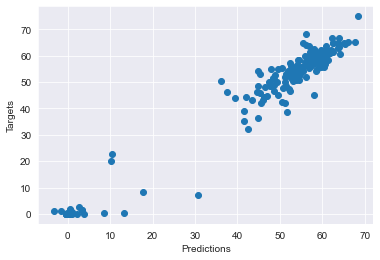

Minimas: [ 7.10399715 24.66051254]
Maximas: [ 0.081391   10.61530023 58.01789178]
Bin Limits: [-3.2836077828228665, 7.103997154256467, 24.660512540869426, 68.40549671251337]
Kernel density plot


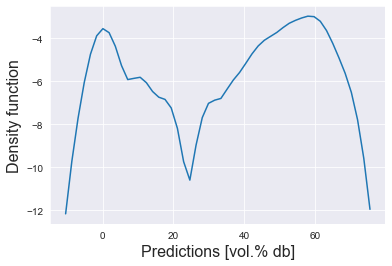

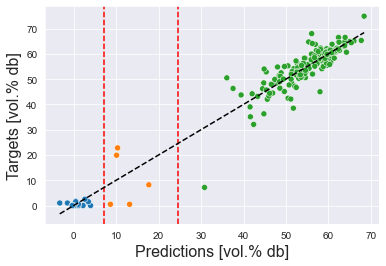

R2 values: [-2.9042753019591006, -0.27784088339044843, 0.7104416970534859]
RMSE value: [1.3019879388229392, 10.665370060648973, 4.3556987687830775]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[7.103997154256467, 24.660512540869426]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMSE,"[1.3019879388229392, 10.665370060648973, 4.355...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R2,"[-2.9042753019591006, -0.27784088339044843, 0....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=0, tuned_bandwidth=2.2, storage_df=storage_df)

# Analysis for Output 2: Syngas H2 content

Functions are being executed for H2 [vol.% db]
Averaged CV R2 score:  0.896894294701902
Averaged CV RMSE score:  2.6345922688996604


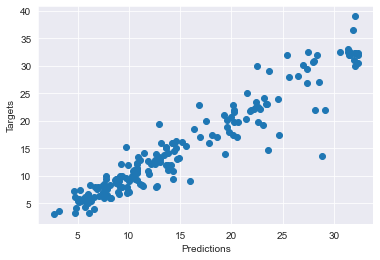

Minimas: [17.8744317  27.33253693]
Maximas: [ 9.87141958 21.51216448 30.24272316]
Bin Limits: [2.65658290245022, 17.874431702870826, 27.332536933411124, 32.36473394709603]
Kernel density plot


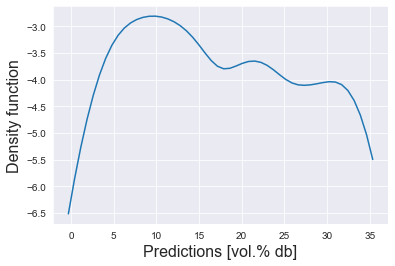

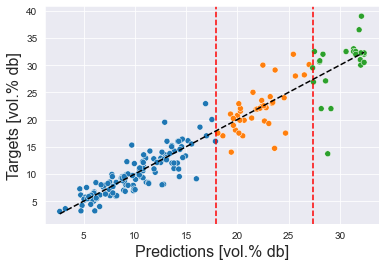

R2 values: [0.7509361760233847, 0.41179086532770826, 0.22745286081716154]
RMSE value: [1.9405359561782811, 3.200434279676321, 4.307687105385578]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[7.103997154256467, 24.660512540869426]","[17.874431702870826, 27.332536933411124]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMSE,"[1.3019879388229392, 10.665370060648973, 4.355...","[1.9405359561782811, 3.200434279676321, 4.3076...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R2,"[-2.9042753019591006, -0.27784088339044843, 0....","[0.7509361760233847, 0.41179086532770826, 0.22...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=1, tuned_bandwidth=2.2, storage_df=storage_df)

# Analysis for Output 3: Syngas CO content

Functions are being executed for CO [vol.% db]
Averaged CV R2 score:  0.9413467302401182
Averaged CV RMSE score:  2.3222929674510535


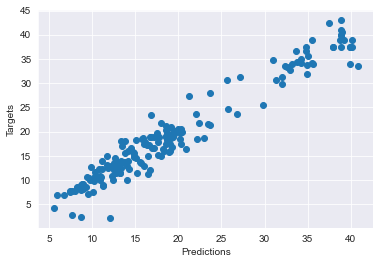

Minimas: [27.94808519]
Maximas: [13.22027018 36.61150578]
Bin Limits: [5.4953868117007945, 27.94808518717715, 40.87102090811048]
Kernel density plot


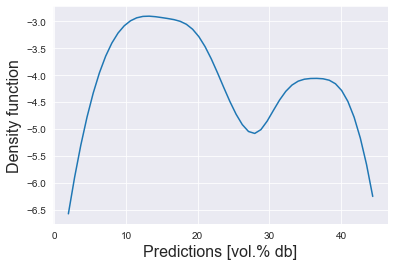

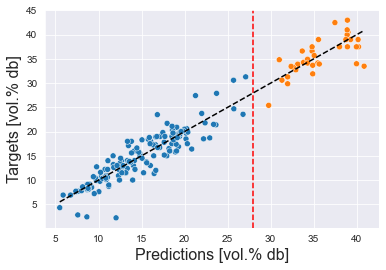

R2 values: [0.8176516865119186, 0.49271019434991825]
RMSE value: [2.253470219036796, 2.5805378695930545]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[7.103997154256467, 24.660512540869426]","[17.874431702870826, 27.332536933411124]",[27.94808518717715],NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMSE,"[1.3019879388229392, 10.665370060648973, 4.355...","[1.9405359561782811, 3.200434279676321, 4.3076...","[2.253470219036796, 2.5805378695930545]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
R2,"[-2.9042753019591006, -0.27784088339044843, 0....","[0.7509361760233847, 0.41179086532770826, 0.22...","[0.8176516865119186, 0.49271019434991825]",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=2, tuned_bandwidth=2.5, storage_df=storage_df)

# Analysis for Output 4: Syngas CO2 content

Functions are being executed for CO2 [vol.% db]
Averaged CV R2 score:  0.9416757097350933
Averaged CV RMSE score:  1.6004090518289704


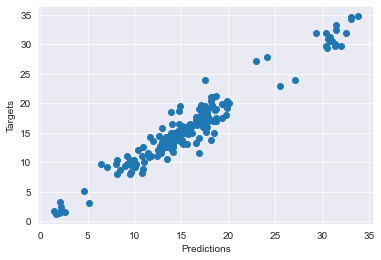

Minimas: [ 4.50260769 25.16256524]
Maximas: [ 2.91338018 15.62720021 31.51947525]
Bin Limits: [1.3903704907121528, 4.5026076860334685, 25.162565237953693, 33.83709869725352]
Kernel density plot


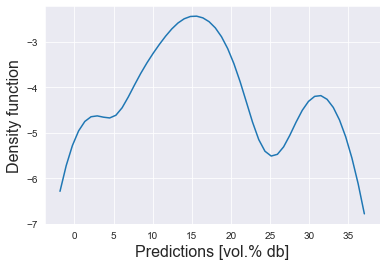

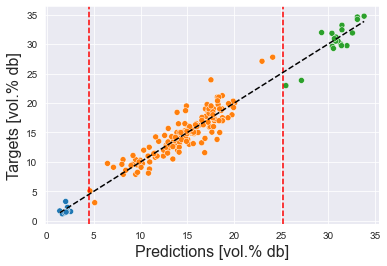

R2 values: [-0.24159109682065472, 0.8028324096436805, 0.718506764167032]
RMSE value: [0.6653426748785727, 1.6423070444711487, 1.5467489739019018]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[7.103997154256467, 24.660512540869426]","[17.874431702870826, 27.332536933411124]",[27.94808518717715],"[4.5026076860334685, 25.162565237953693]",NaN,NaN,NaN,NaN,NaN,NaN
RMSE,"[1.3019879388229392, 10.665370060648973, 4.355...","[1.9405359561782811, 3.200434279676321, 4.3076...","[2.253470219036796, 2.5805378695930545]","[0.6653426748785727, 1.6423070444711487, 1.546...",NaN,NaN,NaN,NaN,NaN,NaN
R2,"[-2.9042753019591006, -0.27784088339044843, 0....","[0.7509361760233847, 0.41179086532770826, 0.22...","[0.8176516865119186, 0.49271019434991825]","[-0.24159109682065472, 0.8028324096436805, 0.7...",NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=3, tuned_bandwidth=2.2, storage_df=storage_df)

# Analysis for Output 5: Syngas CH4 content

Functions are being executed for CH4 [vol.% db]
Averaged CV R2 score:  0.8828638432331847
Averaged CV RMSE score:  0.9461761317052727


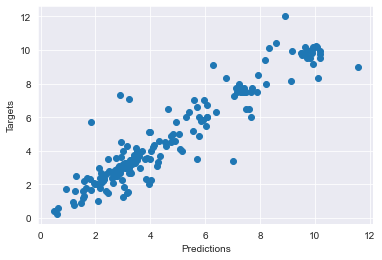

Minimas: [6.43396308 8.60798338]
Maximas: [2.9011801  7.24922069 9.69499353]
Bin Limits: [0.4780533124470037, 6.433963081911612, 8.60798337798995, 11.574615240346844]
Kernel density plot


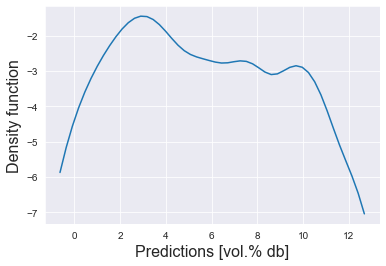

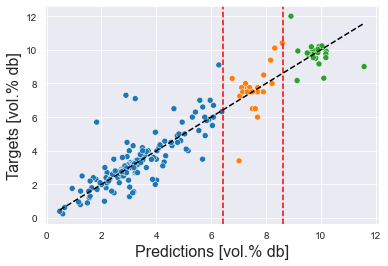

R2 values: [0.6659970332281182, 0.2677867680354714, -0.9735229623302886]
RMSE value: [0.9039228253790674, 1.129410876519344, 1.0224292461575668]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[7.103997154256467, 24.660512540869426]","[17.874431702870826, 27.332536933411124]",[27.94808518717715],"[4.5026076860334685, 25.162565237953693]","[6.433963081911612, 8.60798337798995]",NaN,NaN,NaN,NaN,NaN
RMSE,"[1.3019879388229392, 10.665370060648973, 4.355...","[1.9405359561782811, 3.200434279676321, 4.3076...","[2.253470219036796, 2.5805378695930545]","[0.6653426748785727, 1.6423070444711487, 1.546...","[0.9039228253790674, 1.129410876519344, 1.0224...",NaN,NaN,NaN,NaN,NaN
R2,"[-2.9042753019591006, -0.27784088339044843, 0....","[0.7509361760233847, 0.41179086532770826, 0.22...","[0.8176516865119186, 0.49271019434991825]","[-0.24159109682065472, 0.8028324096436805, 0.7...","[0.6659970332281182, 0.2677867680354714, -0.97...",NaN,NaN,NaN,NaN,NaN


In [12]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=4, tuned_bandwidth=0.7, storage_df=storage_df)

# Analysis for Output 6: Syngas C2Hn content

Functions are being executed for C2Hn [vol.% db]
Averaged CV R2 score:  0.8354183113516676
Averaged CV RMSE score:  0.4505971654620756


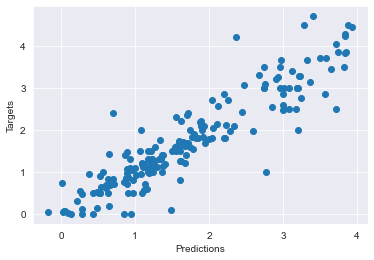

Minimas: [1.42759226 2.53533303 3.54237009]
Maximas: [1.12548114 1.62899967 3.03885156 3.7437775 ]
Bin Limits: [-0.17527506676109192, 1.42759225784703, 2.5353330266861507, 3.5423700892671697, 3.9367929387780687]
Kernel density plot


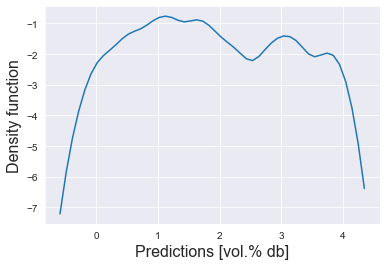

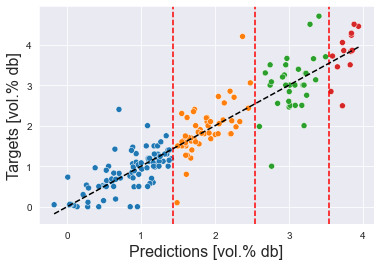

R2 values: [0.4479299005397168, 0.3984135805567347, 0.16894832855705555, 0.21808119753098043]
RMSE value: [0.36603390095142724, 0.4474492466712183, 0.60620338522039, 0.5050415799248026]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[7.103997154256467, 24.660512540869426]","[17.874431702870826, 27.332536933411124]",[27.94808518717715],"[4.5026076860334685, 25.162565237953693]","[6.433963081911612, 8.60798337798995]","[1.42759225784703, 2.5353330266861507, 3.54237...",NaN,NaN,NaN,NaN
RMSE,"[1.3019879388229392, 10.665370060648973, 4.355...","[1.9405359561782811, 3.200434279676321, 4.3076...","[2.253470219036796, 2.5805378695930545]","[0.6653426748785727, 1.6423070444711487, 1.546...","[0.9039228253790674, 1.129410876519344, 1.0224...","[0.36603390095142724, 0.4474492466712183, 0.60...",NaN,NaN,NaN,NaN
R2,"[-2.9042753019591006, -0.27784088339044843, 0....","[0.7509361760233847, 0.41179086532770826, 0.22...","[0.8176516865119186, 0.49271019434991825]","[-0.24159109682065472, 0.8028324096436805, 0.7...","[0.6659970332281182, 0.2677867680354714, -0.97...","[0.4479299005397168, 0.3984135805567347, 0.168...",NaN,NaN,NaN,NaN


In [13]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=5, tuned_bandwidth=0.17, storage_df=storage_df)

# Analysis for Output 7: Syngas LHV

Functions are being executed for LHV [MJ/Nm3]
Averaged CV R2 score:  0.9407787088945175
Averaged CV RMSE score:  0.5919588387362809


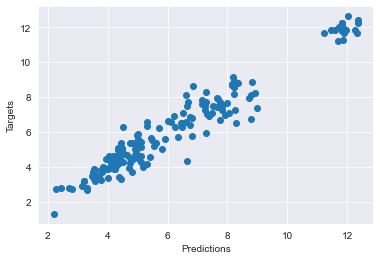

Minimas: [ 6.15988209 10.14519213]
Maximas: [ 4.16722707  7.65437335 11.88876527]
Bin Limits: [2.195328875965759, 6.159882090698806, 10.14519212854564, 12.366172201720698]
Kernel density plot


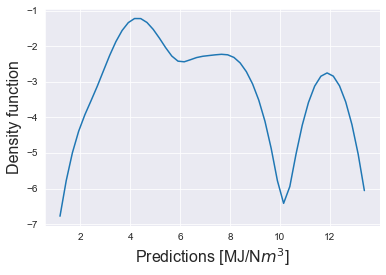

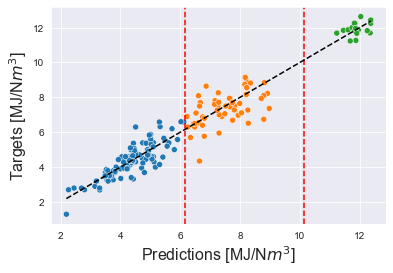

R2 values: [0.7174647211781389, 0.23510515189567527, -0.11917039856974365]
RMSE value: [0.4762977988051116, 0.8294947455038496, 0.3707010544319724]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[7.103997154256467, 24.660512540869426]","[17.874431702870826, 27.332536933411124]",[27.94808518717715],"[4.5026076860334685, 25.162565237953693]","[6.433963081911612, 8.60798337798995]","[1.42759225784703, 2.5353330266861507, 3.54237...","[6.159882090698806, 10.14519212854564]",NaN,NaN,NaN
RMSE,"[1.3019879388229392, 10.665370060648973, 4.355...","[1.9405359561782811, 3.200434279676321, 4.3076...","[2.253470219036796, 2.5805378695930545]","[0.6653426748785727, 1.6423070444711487, 1.546...","[0.9039228253790674, 1.129410876519344, 1.0224...","[0.36603390095142724, 0.4474492466712183, 0.60...","[0.4762977988051116, 0.8294947455038496, 0.370...",NaN,NaN,NaN
R2,"[-2.9042753019591006, -0.27784088339044843, 0....","[0.7509361760233847, 0.41179086532770826, 0.22...","[0.8176516865119186, 0.49271019434991825]","[-0.24159109682065472, 0.8028324096436805, 0.7...","[0.6659970332281182, 0.2677867680354714, -0.97...","[0.4479299005397168, 0.3984135805567347, 0.168...","[0.7174647211781389, 0.23510515189567527, -0.1...",NaN,NaN,NaN


In [14]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=6, tuned_bandwidth=0.5, storage_df=storage_df)

# Analysis for Output 8: Syngas Tar content

Functions are being executed for Tar [g/Nm3]
Averaged CV R2 score:  0.7701638698139173
Averaged CV RMSE score:  10.089992368881445


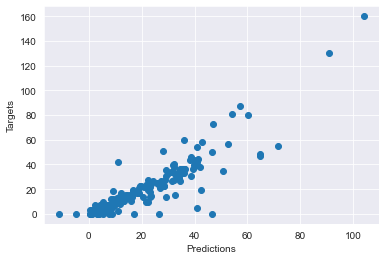

Minimas: [84.52566679]
Maximas: [11.12363295 95.81828738]
Bin Limits: [-11.226345308401825, 84.5256667919883, 104.05248989845607]
Kernel density plot


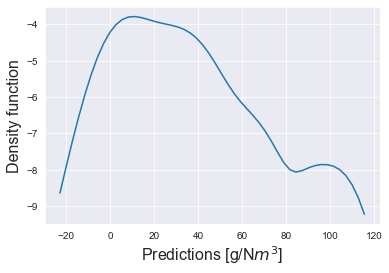

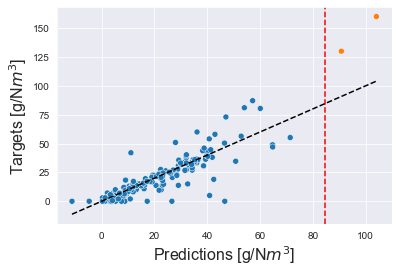

R2 values: [0.742089132626704, -9.371169700627565]
RMSE value: [8.794483003147903, 48.306450735292096]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[7.103997154256467, 24.660512540869426]","[17.874431702870826, 27.332536933411124]",[27.94808518717715],"[4.5026076860334685, 25.162565237953693]","[6.433963081911612, 8.60798337798995]","[1.42759225784703, 2.5353330266861507, 3.54237...","[6.159882090698806, 10.14519212854564]",[84.5256667919883],NaN,NaN
RMSE,"[1.3019879388229392, 10.665370060648973, 4.355...","[1.9405359561782811, 3.200434279676321, 4.3076...","[2.253470219036796, 2.5805378695930545]","[0.6653426748785727, 1.6423070444711487, 1.546...","[0.9039228253790674, 1.129410876519344, 1.0224...","[0.36603390095142724, 0.4474492466712183, 0.60...","[0.4762977988051116, 0.8294947455038496, 0.370...","[8.794483003147903, 48.306450735292096]",NaN,NaN
R2,"[-2.9042753019591006, -0.27784088339044843, 0....","[0.7509361760233847, 0.41179086532770826, 0.22...","[0.8176516865119186, 0.49271019434991825]","[-0.24159109682065472, 0.8028324096436805, 0.7...","[0.6659970332281182, 0.2677867680354714, -0.97...","[0.4479299005397168, 0.3984135805567347, 0.168...","[0.7174647211781389, 0.23510515189567527, -0.1...","[0.742089132626704, -9.371169700627565]",NaN,NaN


In [15]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=7, tuned_bandwidth=8, storage_df=storage_df)

# Analysis for Output 9: Syngas Yield

Functions are being executed for Gas yield [Nm3/kg wb]
Averaged CV R2 score:  0.9561069448624311
Averaged CV RMSE score:  0.2057572790816375


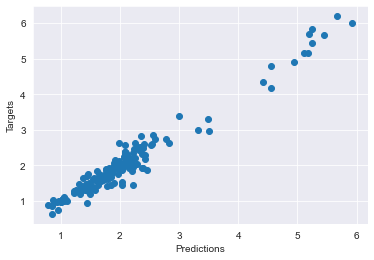

Minimas: [3.29397078 3.92405811]
Maximas: [1.90777865 3.41998825 5.18423277]
Bin Limits: [0.7841229143242762, 3.293970780395307, 3.924058110789708, 5.929836112545217]
Kernel density plot


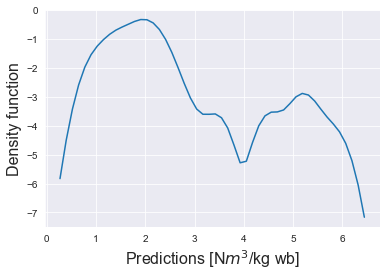

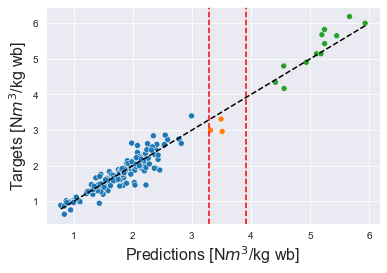

R2 values: [0.8484619826834008, -4.9329895381789015, 0.7453920207635296]
RMSE value: [0.19223892701144968, 0.3819224531045292, 0.30820093190781744]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[7.103997154256467, 24.660512540869426]","[17.874431702870826, 27.332536933411124]",[27.94808518717715],"[4.5026076860334685, 25.162565237953693]","[6.433963081911612, 8.60798337798995]","[1.42759225784703, 2.5353330266861507, 3.54237...","[6.159882090698806, 10.14519212854564]",[84.5256667919883],"[3.293970780395307, 3.924058110789708]",NaN
RMSE,"[1.3019879388229392, 10.665370060648973, 4.355...","[1.9405359561782811, 3.200434279676321, 4.3076...","[2.253470219036796, 2.5805378695930545]","[0.6653426748785727, 1.6423070444711487, 1.546...","[0.9039228253790674, 1.129410876519344, 1.0224...","[0.36603390095142724, 0.4474492466712183, 0.60...","[0.4762977988051116, 0.8294947455038496, 0.370...","[8.794483003147903, 48.306450735292096]","[0.19223892701144968, 0.3819224531045292, 0.30...",NaN
R2,"[-2.9042753019591006, -0.27784088339044843, 0....","[0.7509361760233847, 0.41179086532770826, 0.22...","[0.8176516865119186, 0.49271019434991825]","[-0.24159109682065472, 0.8028324096436805, 0.7...","[0.6659970332281182, 0.2677867680354714, -0.97...","[0.4479299005397168, 0.3984135805567347, 0.168...","[0.7174647211781389, 0.23510515189567527, -0.1...","[0.742089132626704, -9.371169700627565]","[0.8484619826834008, -4.9329895381789015, 0.74...",NaN


In [16]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=8, tuned_bandwidth=0.23, storage_df=storage_df)

# Analysis for Output 10: Char Yield

Functions are being executed for Char yield [g/kg wb]
Averaged CV R2 score:  0.8246006834892248
Averaged CV RMSE score:  22.30285623550412


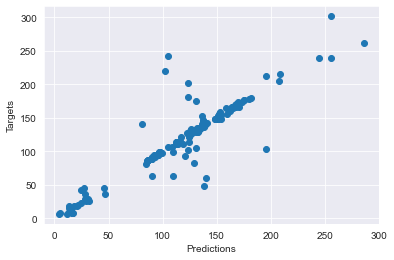

Minimas: [ 59.02374716 231.37360593]
Maximas: [ 17.65978106 127.96369067 252.05558898]
Bin Limits: [4.446291890122459, 59.023747164802955, 231.37360592695188, 285.9510612016324]
Kernel density plot


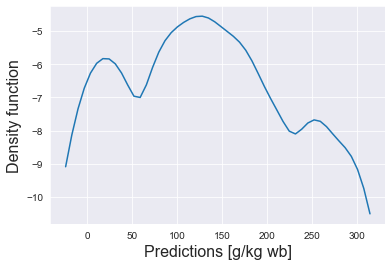

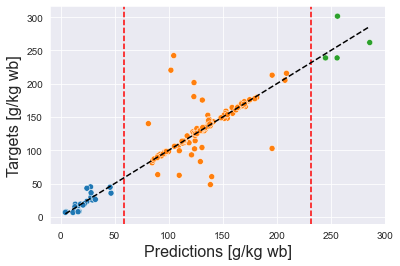

R2 values: [0.6595370837823644, 0.5173849578315286, -0.12911211963740632]
RMSE value: [7.261895145385168, 23.65583121803074, 27.232403308382494]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[7.103997154256467, 24.660512540869426]","[17.874431702870826, 27.332536933411124]",[27.94808518717715],"[4.5026076860334685, 25.162565237953693]","[6.433963081911612, 8.60798337798995]","[1.42759225784703, 2.5353330266861507, 3.54237...","[6.159882090698806, 10.14519212854564]",[84.5256667919883],"[3.293970780395307, 3.924058110789708]","[59.023747164802955, 231.37360592695188]"
RMSE,"[1.3019879388229392, 10.665370060648973, 4.355...","[1.9405359561782811, 3.200434279676321, 4.3076...","[2.253470219036796, 2.5805378695930545]","[0.6653426748785727, 1.6423070444711487, 1.546...","[0.9039228253790674, 1.129410876519344, 1.0224...","[0.36603390095142724, 0.4474492466712183, 0.60...","[0.4762977988051116, 0.8294947455038496, 0.370...","[8.794483003147903, 48.306450735292096]","[0.19223892701144968, 0.3819224531045292, 0.30...","[7.261895145385168, 23.65583121803074, 27.2324..."
R2,"[-2.9042753019591006, -0.27784088339044843, 0....","[0.7509361760233847, 0.41179086532770826, 0.22...","[0.8176516865119186, 0.49271019434991825]","[-0.24159109682065472, 0.8028324096436805, 0.7...","[0.6659970332281182, 0.2677867680354714, -0.97...","[0.4479299005397168, 0.3984135805567347, 0.168...","[0.7174647211781389, 0.23510515189567527, -0.1...","[0.742089132626704, -9.371169700627565]","[0.8484619826834008, -4.9329895381789015, 0.74...","[0.6595370837823644, 0.5173849578315286, -0.12..."


In [17]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=9, tuned_bandwidth=15, storage_df=storage_df)

# Show final dataframe and pickle for later use


In [18]:
# Show dataframe with final boundaries and error scores
storage_df

,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[7.103997154256467, 24.660512540869426]","[17.874431702870826, 27.332536933411124]",[27.94808518717715],"[4.5026076860334685, 25.162565237953693]","[6.433963081911612, 8.60798337798995]","[1.42759225784703, 2.5353330266861507, 3.54237...","[6.159882090698806, 10.14519212854564]",[84.5256667919883],"[3.293970780395307, 3.924058110789708]","[59.023747164802955, 231.37360592695188]"
RMSE,"[1.3019879388229392, 10.665370060648973, 4.355...","[1.9405359561782811, 3.200434279676321, 4.3076...","[2.253470219036796, 2.5805378695930545]","[0.6653426748785727, 1.6423070444711487, 1.546...","[0.9039228253790674, 1.129410876519344, 1.0224...","[0.36603390095142724, 0.4474492466712183, 0.60...","[0.4762977988051116, 0.8294947455038496, 0.370...","[8.794483003147903, 48.306450735292096]","[0.19223892701144968, 0.3819224531045292, 0.30...","[7.261895145385168, 23.65583121803074, 27.2324..."
R2,"[-2.9042753019591006, -0.27784088339044843, 0....","[0.7509361760233847, 0.41179086532770826, 0.22...","[0.8176516865119186, 0.49271019434991825]","[-0.24159109682065472, 0.8028324096436805, 0.7...","[0.6659970332281182, 0.2677867680354714, -0.97...","[0.4479299005397168, 0.3984135805567347, 0.168...","[0.7174647211781389, 0.23510515189567527, -0.1...","[0.742089132626704, -9.371169700627565]","[0.8484619826834008, -4.9329895381789015, 0.74...","[0.6595370837823644, 0.5173849578315286, -0.12..."


In [19]:
# Store for later use
import pickle
# Store Performance summary data frame of best performing model
with open("output\prediction_boundaries_and_errors_df", "wb") as f:
    pickle.dump(storage_df, f)

# # Example of how pickled data frame can be loaded
# with open("output\prediction_boundaries_and_errors_df", "rb") as f:
#     loaded_df = pickle.load(f)


In [22]:
# Also store data as toml file
import toml
from functions.general.utility import get_project_root

project_root = get_project_root()
file_name = str(project_root) + r"\data\prediction_boundaries_and_errors_df.toml"
with open(file_name, "w") as toml_file:
    toml.dump(storage_df.to_dict(), toml_file)


# Unused Code - Fisher-Jenks Algorithm

In [20]:
# # Implementation of Fisher-Jenks Algorithm
# # Currently unused as kernel density estimation has been producing better results
#
# def calculate_bins(nb_class):
#     import pandas as pd
#     import jenkspy
#
#     jenkspy_breaks = jenkspy.jenks_breaks(summary_df['predictions'], nb_class)
#     breaks = jenkspy_breaks.copy()
#     breaks.remove(max(breaks))
#     breaks.remove(min(breaks))
#
#     summary_df['bins'] = pd.cut(summary_df['predictions'],
#                                        bins=jenkspy_breaks,
#                                        labels=['bucket_1', 'bucket_2'],
#                                        include_lowest=True)
#     # write lambda function to insert bucket lables accoridng to nb_class
#     return breaks, summary_df
#
# breaks, summary_df = calculate_bins(2)
# print('Break point(s) are: ', breaks)
#
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.scatterplot(x='predictions', y='targets', data=summary_df, hue='bins')
# #sns.lmplot(x='predictions', y='targets', data=summary_df, hue='bins', fit_reg=False)
# plt.show()